### Try using the SB cut method to calculate the ICL in the artificial data and compare to the "ground truth"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/z5214005/ml_icl')

In [11]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

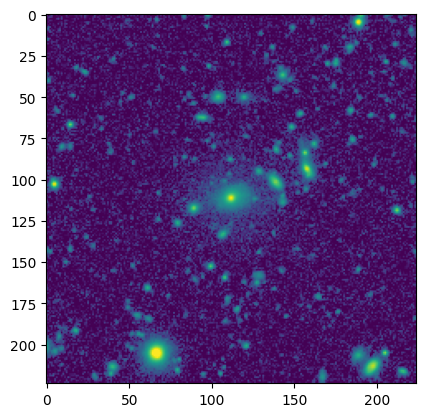

In [17]:
# If I use the same SB cut method to calculate the ICL 
# fraction of the artificial data, what do I get?
from measure_sb_cut.scripts import measure_icl 
from astropy.cosmology import FlatLambdaCDM
import h5py
from astropy.io import ascii

gen_cutouts = h5py.File('/srv/scratch/mltidal/generated_data_wparams.hdf')
lrg_info = ascii.read('/srv/scratch/z5214005/lrgs_sampled.tbl')
keys = lrg_info['new_ids']
zs = lrg_info['z']

# Measure a cutout, following the method in measure_icl.py
num = 1234
key = keys[num]
cutout = gen_cutouts[key]['HDU0']['DATA']
cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)
circ_mask = measure_icl.create_circular_mask(zs[num], cutout, cosmo, 350)
plt.imshow(stretch(cutout) * circ_mask)
plt.show()

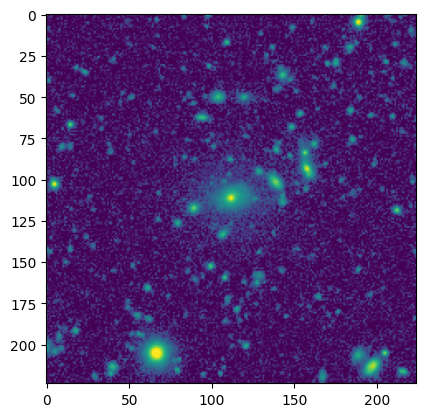

In [9]:
# Background estimate
bkg = measure_icl.background_estimate(cutout, zs[num], cosmo)
bkg_subtracted = cutout - bkg
plt.imshow(stretch(bkg_subtracted))
plt.show()

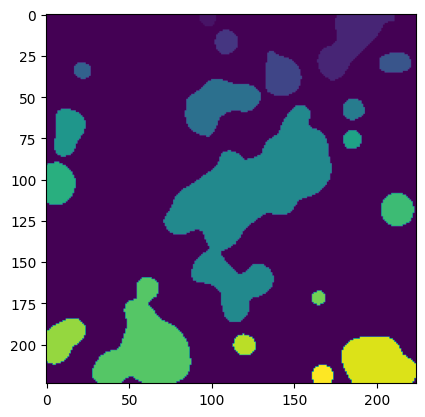

In [10]:
# Segment the image
cold_labels = measure_icl.create_cold_labels(cutout, np.zeros(cutout.shape, dtype=bool))
# Create cold mask
cold_mask = measure_icl.enlarge_mask(cold_labels, sigma=2)
plt.imshow(cold_labels)
plt.show()

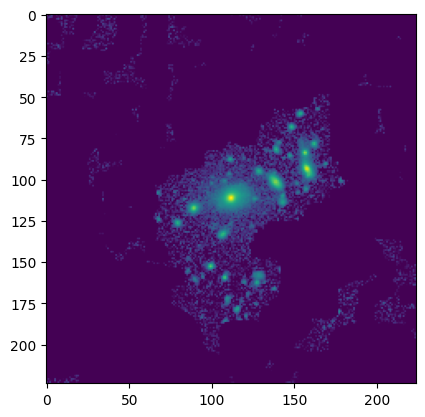

In [11]:
# Unsharp mask the image for hot mask creation
from astropy.convolution import Gaussian2DKernel, convolve
kernel = Gaussian2DKernel(5) 
conv_img = convolve(np.array(cutout), kernel)
unsharp = np.array(cutout) - conv_img

# Create hot mask
hot_mask_bkg = measure_icl.background_estimate(unsharp, zs[num], cosmo=cosmo)
hot_labels = measure_icl.create_hot_labels(unsharp, cold_mask, background=hot_mask_bkg)
hot_mask = measure_icl.enlarge_mask(hot_labels, sigma=1)

# Create the "member mask"
mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
bcg_label = cold_labels[mid[0], mid[1]]
member_mask = (cold_labels == bcg_label) | (cold_labels == 0)
non_member_mask = ~member_mask
non_member_mask = measure_icl.enlarge_mask(non_member_mask, sigma=2)
non_member_mask = non_member_mask + hot_mask
member_mask = ~non_member_mask
plt.imshow(stretch(cutout) * member_mask)
plt.show()

/tmp/ipykernel_1609958/673593499.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


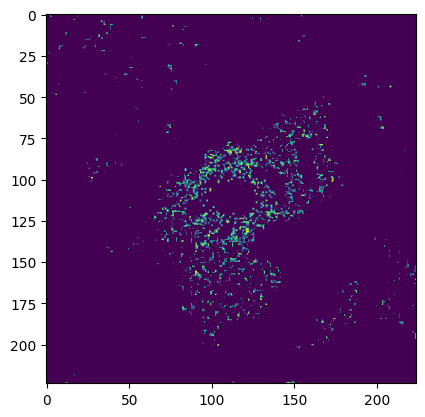

Calculated fraction = 0.07911605574680367
Actual fraction = 0.169455865914964


In [12]:
# Calculate surface brightness limit
from astropy.stats import sigma_clipped_stats
_, _, stddev = sigma_clipped_stats(bkg_subtracted)
sb_lim = -2.5 * np.log10(3 * stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

# Convert image from counts to surface brightness
np.seterr(invalid='ignore', divide='ignore')
sb_img = measure_icl.counts2sb(bkg_subtracted, 0)

# Mask values below surface brightness limit
sb_img[sb_img >= sb_lim] = np.nan

# Mask above the surface brightness threshold
threshold = 26 + 10 * np.log10(1 + zs[num])
mask = sb_img > threshold

# Convert the SB image back to counts
counts_img = measure_icl.sb2counts(sb_img) 

# Display the final image
masked_img = counts_img * member_mask

cmap = plt.cm.get_cmap('viridis')
cmap.set_bad(cmap(0))
plt.imshow(stretch(masked_img) * mask, cmap=cmap)
plt.show()

# Calculate the ICL fraction
print(f'Calculated fraction = {np.nansum(masked_img * mask) / np.nansum(masked_img)}')
print(f'Actual fraction = {gen_cutouts[key]["FRAC"][()]}')

In [13]:
zs = lrg_info['z']

# Look at the offsets of the measured values compared to the fake values for the actual data
def calc_icl_frac(cutout, num):
    plt.figure(figsize=(8,8))
    plt.subplot(221)
    plt.imshow(stretch(cutout))
    # Background estimate
    bkg = measure_icl.background_estimate(cutout, zs[num], cosmo)
    bkg_subtracted = cutout - bkg
    plt.subplot(222)
    plt.imshow(stretch(bkg_subtracted))
    # Segment the image
    cold_labels = measure_icl.create_cold_labels(cutout, np.zeros(cutout.shape, dtype=bool))
    # Create cold mask
    cold_mask = measure_icl.enlarge_mask(cold_labels, sigma=2)

    # Unsharp mask the image for hot mask creation
    kernel = Gaussian2DKernel(5) 
    conv_img = convolve(np.array(cutout), kernel)
    unsharp = np.array(cutout) - conv_img

    # Create hot mask
    hot_mask_bkg = measure_icl.background_estimate(unsharp, zs[num], cosmo=cosmo)
    hot_labels = measure_icl.create_hot_labels(unsharp, cold_mask, background=hot_mask_bkg)
    hot_mask = measure_icl.enlarge_mask(hot_labels, sigma=1)

    # Create the "member mask"
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    bcg_label = cold_labels[mid[0], mid[1]]
    member_mask = (cold_labels == bcg_label) | (cold_labels == 0)
    non_member_mask = ~member_mask
    non_member_mask = measure_icl.enlarge_mask(non_member_mask, sigma=2)
    non_member_mask = non_member_mask + hot_mask
    member_mask = ~non_member_mask
    plt.subplot(223)
    plt.imshow(stretch(cutout * member_mask))

    # Calculate surface brightness limit
    _, _, stddev = sigma_clipped_stats(bkg_subtracted)
    sb_lim = -2.5 * np.log10(3 * stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

    # Convert image from counts to surface brightness
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = measure_icl.counts2sb(bkg_subtracted, 0)

    # Mask values below surface brightness limit
    sb_img[sb_img >= sb_lim] = np.nan

    # Mask above the surface brightness threshold
    threshold = 26 + 10 * np.log10(1 + zs[num])
    mask = sb_img > threshold

    # Convert the SB image back to counts
    counts_img = measure_icl.sb2counts(sb_img) 

    # Display the final image
    masked_img = counts_img * member_mask
    plt.subplot(224)
    plt.imshow(stretch(masked_img) * mask)

    return np.nansum(masked_img * mask) / np.nansum(masked_img)

def make_bkg_subtracted_img(cutout, num):
    bkg = measure_icl.background_estimate(cutout, zs[num], cosmo)
    bkg_subtracted = cutout - bkg
    return bkg_subtracted

def make_member_mask_img(cutout, num):
    bkg_subtracted = make_bkg_subtracted_img(cutout, num)
    # Segment the image
    cold_labels = measure_icl.create_cold_labels(cutout, np.zeros(cutout.shape, dtype=bool))
    # Create cold mask
    cold_mask = measure_icl.enlarge_mask(cold_labels, sigma=2)

    # Unsharp mask the image for hot mask creation
    kernel = Gaussian2DKernel(5) 
    conv_img = convolve(np.array(cutout), kernel)
    unsharp = np.array(cutout) - conv_img

    # Create hot mask
    hot_mask_bkg = measure_icl.background_estimate(unsharp, zs[num], cosmo=cosmo)
    hot_labels = measure_icl.create_hot_labels(unsharp, cold_mask, background=hot_mask_bkg)
    hot_mask = measure_icl.enlarge_mask(hot_labels, sigma=1)

    # Create the "member mask"
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    bcg_label = cold_labels[mid[0], mid[1]]
    member_mask = (cold_labels == bcg_label) | (cold_labels == 0)
    non_member_mask = ~member_mask
    non_member_mask = measure_icl.enlarge_mask(non_member_mask, sigma=2)
    non_member_mask = non_member_mask + hot_mask
    member_mask = ~non_member_mask
    return member_mask

def make_threshold_mask(cutout, num):
    bkg_subtracted = make_bkg_subtracted_img(cutout, num)

    # Calculate surface brightness limit
    _, _, stddev = sigma_clipped_stats(bkg_subtracted)
    sb_lim = -2.5 * np.log10(3 * stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

    # Convert image from counts to surface brightness
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = measure_icl.counts2sb(bkg_subtracted, 0)

    # Mask values below surface brightness limit
    sb_img[sb_img >= sb_lim] = np.nan

    # Mask above the surface brightness threshold
    threshold = 25 + 10 * np.log10(1 + zs[num])
    mask = sb_img > threshold
    return mask

def make_final_masked_img(cutout, num, custom_mask=None):
    bkg_subtracted = make_bkg_subtracted_img(cutout, num)
    member_mask = make_member_mask_img(cutout, num)
    # Calculate surface brightness limit
    _, _, stddev = sigma_clipped_stats(bkg_subtracted)
    sb_lim = -2.5 * np.log10(3 * stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

    # Convert image from counts to surface brightness
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = measure_icl.counts2sb(bkg_subtracted, 0)

    # Mask values below surface brightness limit
    sb_img[sb_img >= sb_lim] = np.nan

    # Mask above the surface brightness threshold
    threshold = 25 + 10 * np.log10(1 + zs[num])
    mask = sb_img > threshold
    if custom_mask is not None:
        mask = custom_mask

    # Convert the SB image back to counts
    counts_img = measure_icl.sb2counts(sb_img) 

    # Display the final image
    masked_img = counts_img * member_mask
    
    return masked_img * mask

In [14]:
# Takes around 10 minutes to run
random_subset = np.random.randint(0, len(keys), size=1000)

measured = []
true = []

for num in random_subset:
    cutout = gen_cutouts[keys[num]]['HDU0']['DATA']
    measured.append(calc_icl_frac(cutout, num))
    plt.close()
    true.append(gen_cutouts[keys[num]]['FRAC'][()])

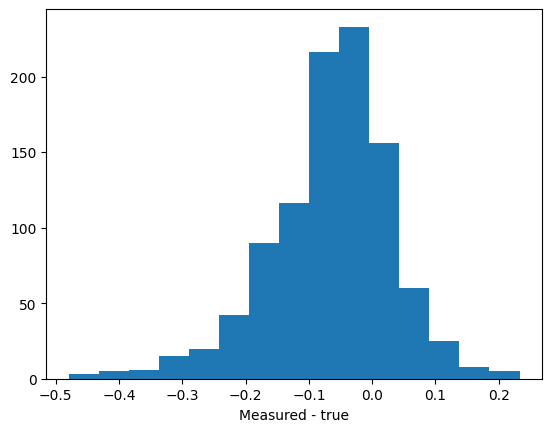

In [15]:
plt.hist(np.array(measured) - np.array(true), bins=15)
plt.xlabel('Measured - true')
plt.show()

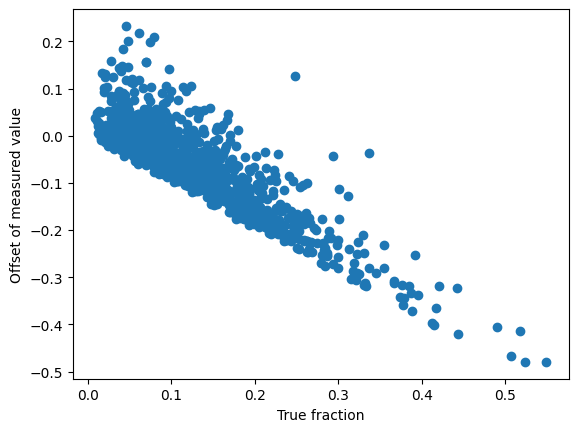

In [16]:
plt.scatter(true, np.array(measured) - np.array(true))
plt.xlabel('True fraction')
plt.ylabel('Offset of measured value')
plt.show()

## Play around with the methods to try to improve agreement

In [1]:
# More experiments with the data generation
from astropy.io import ascii
import h5py
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/z5214005/ml_icl')

In [2]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

In [3]:
cutouts = h5py.File('/srv/scratch/z5214005/lrg_cutouts_resized.hdf')

lrgs = ascii.read('/srv/scratch/z5214005/lrgs_sampled.tbl')
keys = lrgs['new_ids']
zs = lrgs['z']

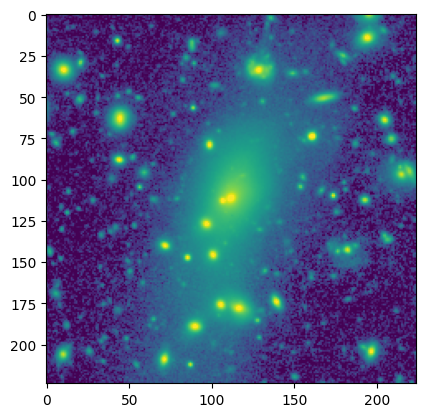

In [20]:
cutout_num = 5097

key = keys[cutout_num]

cutout = cutouts[key]['HDU0']['DATA']

plt.imshow(stretch(cutout))
plt.show()

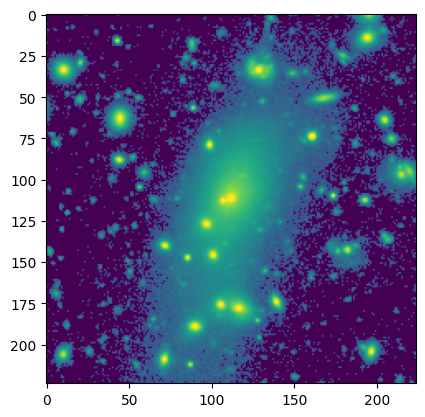

In [21]:
z = zs[cutout_num]

# Generate the surface brightness threshold
sb_threshold = 26 + 10 * np.log10(1 + z)
threshold = 10**(-0.4*(sb_threshold - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))

# Display the cutout with everything below the threshold removed
plt.imshow(stretch(cutout) * (cutout > threshold))
plt.show()

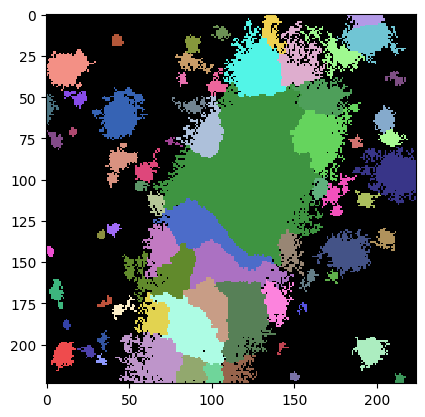

In [22]:
from photutils.segmentation import SourceFinder
import scipy
from skimage.morphology import binary_opening
import skimage

finder = SourceFinder(npixels=20, progress_bar=False, nlevels=8)

# Figure out what to use as r_eff
bright_parts = (cutout > threshold)
segm = finder(cutout, threshold)
labels = segm.data

plt.imshow(labels, cmap=segm.cmap, interpolation='nearest')

centre = (cutout.shape[0] // 2, cutout.shape[1] // 2)
central_blob = bright_parts * (labels == labels[centre[0], centre[1]])

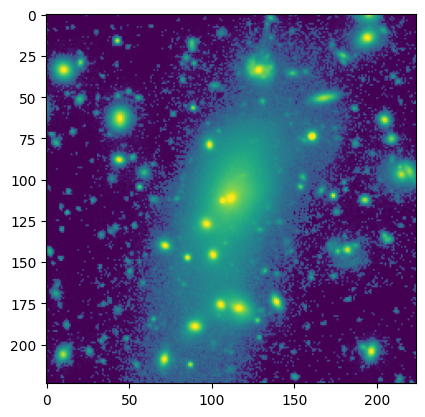

In [23]:
from astropy.convolution import Gaussian2DKernel, convolve
from skimage.morphology import binary_opening

# Expand the masks of non central galaxies
non_central_galaxies = bright_parts * ~central_blob 
kernel = Gaussian2DKernel(7) # Large ish kernel
non_central_blurred = binary_opening(non_central_galaxies) # Erase tiny bright parts (get rid of specks in ICL area)
non_central_blurred = convolve(non_central_blurred, kernel) # Expand masks
# Put just the blurred edges into the original mask
non_central_blurred = np.where(non_central_galaxies | central_blob, non_central_galaxies, non_central_blurred)

final_bright_parts = non_central_blurred + central_blob

plt.imshow(stretch(cutout) * final_bright_parts)
plt.show()

76.8505042273634


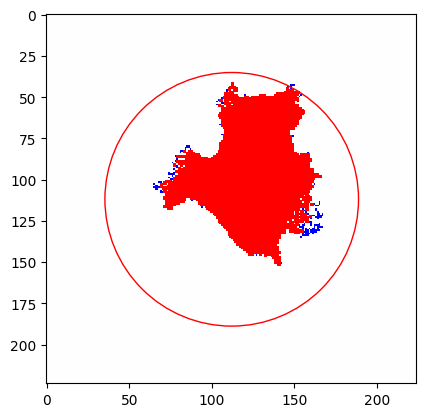

0.03706715703268965 0.3541572913508394 0.970038415154471


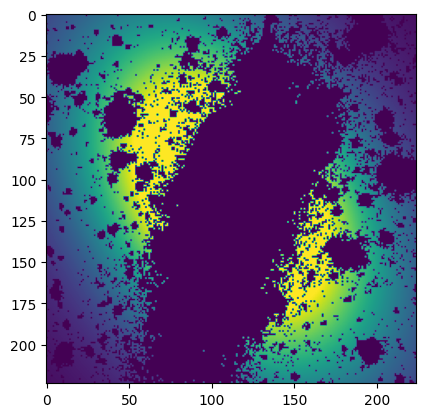

In [47]:
from astropy.modeling.functional_models import Sersic2D
from matplotlib.patches import Circle

opened_blob = binary_opening(central_blob, np.ones((2,2)))
labelled_blob = skimage.measure.label(opened_blob)
opened_blob = opened_blob * (labelled_blob == labelled_blob[centre[0], centre[1]])

edges = scipy.spatial.ConvexHull(np.argwhere(opened_blob)) # Convex hull of central blob

distances = scipy.spatial.distance.cdist([centre], np.argwhere(opened_blob)[edges.vertices])[0] # Distances to edges of shape
# r_eff = np.random.choice(distances) # Vague estimate of size of central blob
# r_eff = np.quantile(distances, 0.25)
r_eff = np.max(distances)
print(r_eff)

plt.imshow(2*opened_blob.astype(int) - central_blob.astype(int), cmap='bwr', interpolation='none')
circle = Circle(centre, r_eff, color='red', fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.show()

# Generate some random parameters for the profile
amplitude = threshold
n = 1 # exponential profile
ellip = np.random.uniform(low=0, high=0.5)
theta = np.random.uniform(low=0, high=2*np.pi)

# Generate the model
model = Sersic2D(amplitude=amplitude, r_eff=r_eff, n=n, x_0=centre[1], y_0=centre[0], ellip=ellip, theta=theta)
x,y = np.meshgrid(np.arange(cutout.shape[1]), np.arange(cutout.shape[0]))

icl_img = np.clip(model(x,y), a_min=None, a_max=threshold)
# icl_img = np.where(central_blob, 0, icl_img)
icl_img = np.where(bright_parts, 0, icl_img)

print(amplitude, ellip, theta)
plt.imshow(stretch(icl_img))
plt.show()

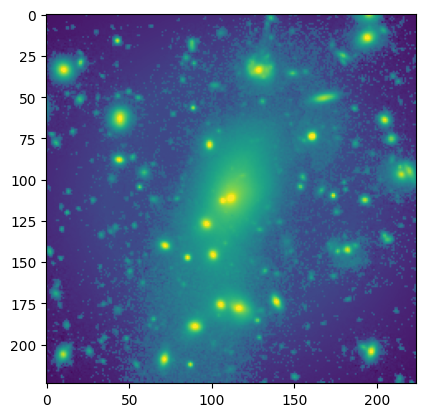

In [25]:
from astropy.stats import mad_std
# Add to the bright parts
img_no_noise = (cutout * final_bright_parts) + icl_img #np.clip(model(x,y), a_min=None, a_max=threshold)

# Generate some noise
std = mad_std(cutout * ~bright_parts) # Standard deviation of the background (+icl)
noise = np.random.normal(loc=0, scale=std, size=cutout.shape)

# Add to final image
img = img_no_noise + noise
# img = cutout + icl_img
img = img.astype('<f4')
plt.imshow(stretch(img))
plt.show()

5780 44396
0.31581052400072224


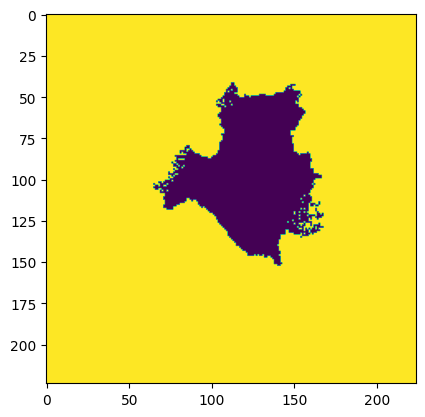

In [26]:
from astropy.stats import sigma_clipped_stats

# Calculate the new artificial ICL fraction
sb_limit = 28 + 10 * np.log10(1+z) # Calculate the sb limit
limit = 10**(-0.4*(sb_limit - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168))) # Convert to counts
icl = np.sum(icl_img[icl_img > limit])

# total = np.sum(img_no_noise) # Total brightness (without considering noise)
_, med, _ = sigma_clipped_stats(cutout)
total = np.sum(((np.array(cutout) - med) * central_blob) + icl_img)

print(np.sum(central_blob), np.sum(icl_img > limit))
plt.imshow(icl_img > limit)

print(icl/total)

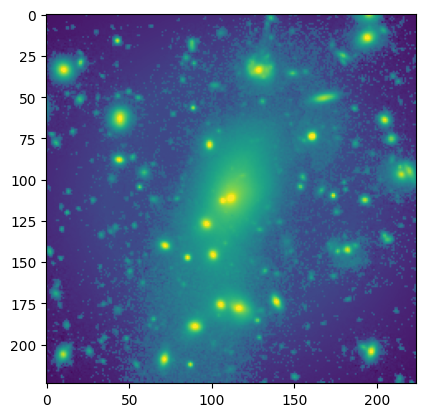

In [27]:
quantile = 0.5
while (np.sum(icl_img > limit) > 8 * np.sum(central_blob)) and quantile > 0:
    # ICL is way too big - likely an irregularly shaped galaxy that we need to be
    # more conservative about when estimating size
    
    r_eff = np.quantile(distances, quantile)
    # Generate the model
    model = Sersic2D(amplitude=amplitude, r_eff=r_eff, n=n, x_0=centre[1], y_0=centre[0], ellip=ellip, theta=theta)
    x,y = np.meshgrid(np.arange(cutout.shape[1]), np.arange(cutout.shape[0]))

    icl_img = np.clip(model(x,y), a_min=None, a_max=threshold)
    icl_img = np.where(central_blob, 0, icl_img)

    # Calculate the new artificial ICL fraction
    sb_limit = 28 + 10 * np.log10(1+z) # Calculate the sb limit
    limit = 10**(-0.4*(sb_limit - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168))) # Convert to counts
    icl = np.sum(icl_img[icl_img > limit])

    # total = np.sum(img_no_noise) # Total brightness (without considering noise)
    _, med, _ = sigma_clipped_stats(cutout)
    total = np.sum(((np.array(cutout) - med) * central_blob) + icl_img)
    print(icl/total)

    quantile -= 0.25

# Add to the bright parts
img_no_noise = (cutout * final_bright_parts) + icl_img #np.clip(model(x,y), a_min=None, a_max=threshold)

# Generate some noise
std = mad_std(cutout * ~bright_parts) # Standard deviation of the background (+icl)
noise = np.random.normal(loc=0, scale=std, size=cutout.shape)

# Add to final image
img = img_no_noise + noise
# img = cutout + icl_img
img = img.astype('<f4')
plt.imshow(stretch(img))
plt.show()

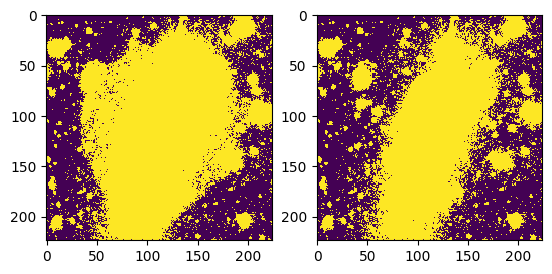

In [46]:
threshold = measure_icl.sb2counts(26 + 10 * np.log10(1+zs[cutout_num]))
plt.subplot(121) 
plt.imshow(img >= threshold, interpolation='none')
plt.subplot(122)
plt.imshow(cutout >= threshold, interpolation='none')
plt.show()

In [41]:
# Now measure this new image
from measure_sb_cut.scripts import measure_icl
from skimage.morphology import binary_closing
from astropy.cosmology import FlatLambdaCDM
from photutils.segmentation import deblend_sources, SegmentationImage
import matplotlib

cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)

def calc_icl_frac(cutout, num, plots=True):
    if plots:
        plt.figure(figsize=(8,8))
        plt.subplot(221)
        plt.imshow(stretch(cutout))
    # Background estimate
    bkg = measure_icl.background_estimate(cutout, zs[num], cosmo)
    bkg_subtracted = cutout# - bkg

    # Segment the image
    cold_labels = measure_icl.create_cold_labels(cutout, np.zeros(cutout.shape, dtype=bool))
    if cold_labels is None:
        print(f'Cutout {num} returns None?? Continuing...')
        cold_labels = np.zeros_like(cutout)
    # deblended = deblend_sources(cutout, SegmentationImage(cold_labels), npixels=20, nlevels=64, progress_bar=False)
    # cold_labels = deblended.data
    if plots:
        plt.subplot(222)
        plt.imshow(cold_labels, interpolation='none')

    # Create cold mask
    cold_mask = measure_icl.enlarge_mask(cold_labels, sigma=0.5)

    # Unsharp mask the image for hot mask creation
    kernel = Gaussian2DKernel(5) 
    conv_img = convolve(np.array(cutout), kernel)
    unsharp = np.array(cutout) - conv_img

    # Create hot mask
    hot_mask_bkg = measure_icl.background_estimate(unsharp, zs[num], cosmo=cosmo)
    hot_labels = measure_icl.create_hot_labels(unsharp, cold_mask, background=hot_mask_bkg)
    hot_mask = measure_icl.enlarge_mask(hot_labels, sigma=0.33)

    # Create the "member mask"
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    # Remove the central blob from the cold labels
    central_blob = cold_labels[mid[0], mid[1]]
    unblobbed = ((cold_labels != 0) & (cold_labels != central_blob)) * cold_labels
    unblobbed = measure_icl.enlarge_mask(unblobbed, sigma=0.66) # Enlarge this mask
    # Calculate new, smaller masks for central galaxies
    threshold = measure_icl.sb2counts(26 + 10 * np.log10(1 + zs[num]))
    finder = SourceFinder(20, progress_bar=False)
    deblended = finder(bkg_subtracted, threshold)
    centrals_newlabels = deblended.data * (cold_labels == central_blob)
    # Renumber
    centrals_newlabels = (np.max(cold_labels) + centrals_newlabels) * centrals_newlabels.astype(bool)
    # Combine to create our new mask
    combined_labels = unblobbed + centrals_newlabels
    # Create the member mask
    bcg_label = combined_labels[mid[0], mid[1]]
    member_mask = (combined_labels == bcg_label) | (combined_labels == 0)
    non_member_mask = ~member_mask
    non_member_mask = non_member_mask + hot_mask
    member_mask = ~non_member_mask

    # Make the circular mask
    # Get the BCG's label
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    bcg_label = combined_labels[mid[0], mid[1]]

    # Coordinates of points that are part of the BCG
    pts = np.array(np.argwhere(combined_labels == bcg_label))

    # Find points that are furthest apart
    candidates = pts[scipy.spatial.ConvexHull(pts).vertices]
    dist_mat = scipy.spatial.distance_matrix(candidates, candidates)
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
    pt1 = candidates[i]
    pt2 = candidates[j]

    size = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

    # Make sure that the radius is >=100kpc
    # radius = np.max((size, cosmo.arcsec_per_kpc_proper(zs[num]).value * 100 * 1/0.168))
    radius = size * 1.5

    # Generate the mask
    centre = (cutout.shape[1] // 2, cutout.shape[0] // 2)
    Y, X = np.ogrid[:cutout.shape[0], :cutout.shape[1]]
    dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)
    circ_mask = dist_from_centre <= radius

    if plots:
        plt.subplot(223)
        plt.imshow(stretch(bkg_subtracted * member_mask * circ_mask))

    # Calculate surface brightness limit
    _, _, stddev = sigma_clipped_stats(bkg_subtracted)
    sb_lim = -2.5 * np.log10(3 * stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

    # Convert image from counts to surface brightness
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = measure_icl.counts2sb(bkg_subtracted, 0)

    # Mask values below surface brightness limit
    sb_img[sb_img >= sb_lim] = np.nan

    # Mask above the surface brightness threshold
    threshold = 26 + 10 * np.log10(1 + zs[num])
    mask = sb_img >= threshold
    plt.imshow(mask, interpolation='none')
    # Close the mask
    mask = binary_closing(mask)

    # Convert the SB image back to counts
    counts_img = measure_icl.sb2counts(sb_img) 

    # Close the nans to try and get rid of the noise that contributes to the ICL?
    nans = np.isnan(counts_img)
    nans = binary_closing(nans)
    not_nans = ~nans

    # Display the final image
    masked_img = counts_img * member_mask * circ_mask * not_nans

    if plots:
        plt.subplot(224)
        cmap = matplotlib.colormaps.get_cmap('viridis')
        cmap.set_bad(cmap(0))
        plt.imshow(stretch(masked_img) * mask, cmap=cmap, interpolation='none')

    icl = np.nansum(masked_img * mask)
    total = np.nansum(masked_img)
    frac = icl / total

    return icl, total, frac

ICL = 205.26722717285156
Total = 2797.651611328125
Frac = 0.07337126135826111
Injected ICL = 1139.0547620843574
Total light = 3606.7663219537058
Actual frac = 0.31581052400072224


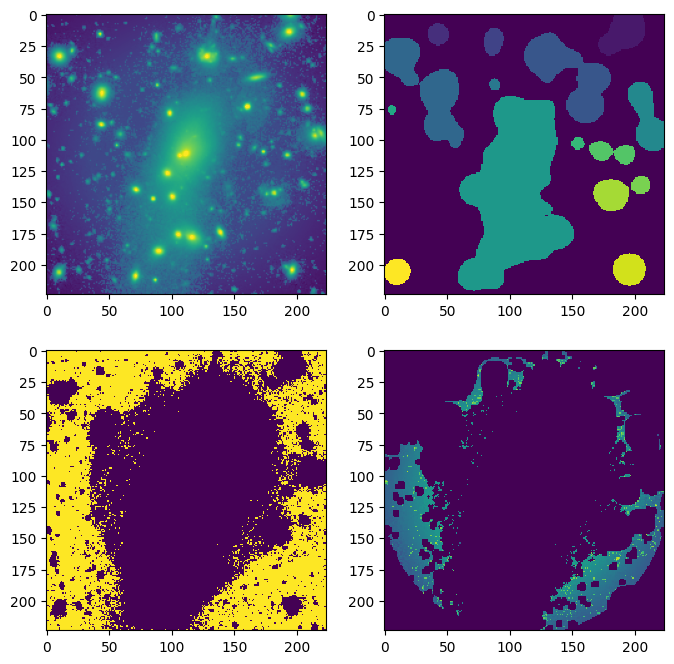

In [42]:
measured_icl, measured_total, frac = calc_icl_frac(img, cutout_num)

print(f'ICL = {measured_icl}')
print(f'Total = {measured_total}')
print(f'Frac = {frac}')

print(f'Injected ICL = {icl}')
print(f'Total light = {total}')
print(f'Actual frac = {icl/total}')

In [15]:
random_subset = np.random.randint(0, len(keys), size=1000)

measured = []
icls = []
totals = []
true = []

gen_cutouts = h5py.File('/srv/scratch/mltidal/generated_data_experiment.hdf')

for num in random_subset:
    cutout = gen_cutouts[keys[num]]['HDU0']['DATA']
    icl, total, frac = calc_icl_frac(cutout, num, plots=False)
    measured.append(frac)
    icls.append(icl)
    totals.append(total)
    true.append(gen_cutouts[keys[num]]['FRAC'][()])

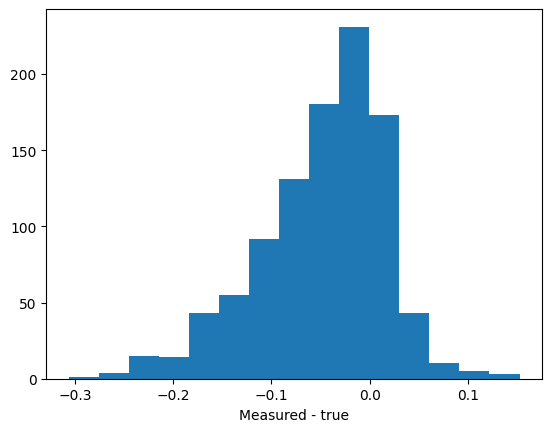

In [16]:
plt.hist(np.array(measured) - np.array(true), bins=15)
plt.xlabel('Measured - true')
plt.show()

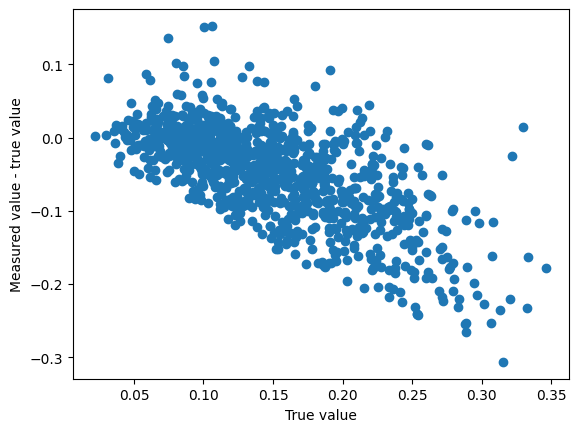

In [18]:
plt.scatter(np.array(true), np.array(measured) - np.array(true))
plt.xlabel('True value')
plt.ylabel('Measured value - true value')
plt.show()

0.3153067929293359 0.009046373582040638
5097
0.3153067929293359


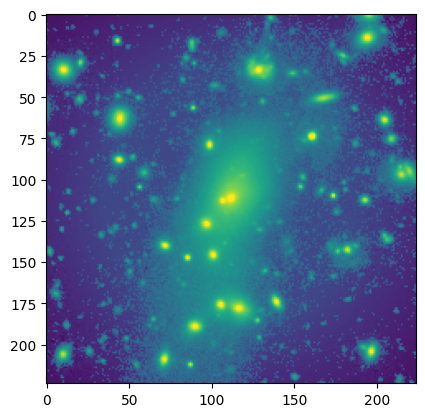

In [19]:
# Find which galaxy is giving the largest discrepancy
max_offset_idx = np.argmin(np.array(measured) - np.array(true)) 
print(true[max_offset_idx], measured[max_offset_idx])

plt.imshow(stretch(gen_cutouts[keys[random_subset[max_offset_idx]]]['HDU0']['DATA']))
print(random_subset[max_offset_idx])
print(gen_cutouts[keys[random_subset[max_offset_idx]]]['FRAC'][()])